In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model

In [2]:
# Pipe and truck transport cost functions

wacc = 0.1
plant_lifetime_yrs = 30
capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)

def truck_costing(distance):
# Fixed Costs

    # Cost taken directly from "Truck versus pipeline transportation cost analysis of wastewater sludge"
    charge_out_rate = 95.1 #$/hr 
    truck_capacity = 30 # m3 


    loading_unloading_rate = 0.4*60 # m3/h arbitrary rate based on ranges in the paper
    loading_unloading_time = truck_capacity/loading_unloading_rate + 20/60  #hr
    
    fixed_cost = charge_out_rate*loading_unloading_time/truck_capacity   #$/m3

    # Variable Costs
    truck_speed = 40*1.6   #km/h
    variable_cost = charge_out_rate/truck_speed/truck_capacity    #$/m3/km

    return (fixed_cost + variable_cost*distance)

def pipe_costing(capacity,distance):

    '''inputs'''

    storage_capacity = capacity* pyunits.m**3/pyunits.day
    pumping_velocity = 1.5 *pyunits.m/pyunits.s
    pump_power = 24 *pyunits.hp
    distance = distance *pyunits.km
    days_operation = 350
    plant_utilization = days_operation/365

    '''Fixed Capital Costs'''

    # Inlet pumping station - based on correlation in "Truck versus pipeline transportation cost analysis of wastewater sludge"
    storage_tank = 1000000*((storage_capacity/9400)*0.65)

    # Valve
    pipe_csa = pyunits.convert(storage_capacity,to_units = pyunits.m**3/pyunits.s)/pumping_velocity
    pipe_diameter = pyunits.convert(2 * (pipe_csa/np.pi)**0.5 , to_units = pyunits.inch)
    fitting_valve_cost = 13220*(pipe_diameter**1.05)

    # Inlet pump
    inlet_pump_cost = 1322*(pump_power**0.8056)

    # Miscellaneous / construction costs --> Taken from reference
    road_access_cost = 320/wacc*plant_utilization
    building_foundation_cost = 1110/wacc*plant_utilization

    # Total inlet and outlet station cost
    total_inlet_station_fixed_capital_cost = storage_tank + fitting_valve_cost + inlet_pump_cost + building_foundation_cost + road_access_cost 
    total_outlet_station_fixed_capital_cost = storage_tank + fitting_valve_cost + building_foundation_cost

    # Total fixed capital cost
    total_fixed_capital_cost = ( total_inlet_station_fixed_capital_cost + total_outlet_station_fixed_capital_cost )*wacc/plant_utilization

    
    ''' Variable Capital Costs'''

    # Booster station costs

    booster_pump_cost = inlet_pump_cost
    booster_pump_installation_cost = 0.1 * total_fixed_capital_cost/wacc*plant_utilization

    # Number of booster pumps 
    minimum_pressure = 2*pyunits.bar
    friction_factor = 0.005
    density = 1000*pyunits.kg/pyunits.m**3
    
    atm_pressure = 1*pyunits.bar
    # pressure_drop = friction_factor*density*(pumping_velocity**2)/(2*pyunits.convert(pipe_diameter,to_units = pyunits.m))*pyunits.convert(distance,to_units = pyunits.m)*1e-5  #bar
    deltaP_grad =  friction_factor*density*(pumping_velocity**2)/(2*pyunits.convert(pipe_diameter,to_units = pyunits.m))*1e-5  #bar/m
    # N = (minimum_pressure + pressure_drop - atm_pressure)/distance
    Pmax = 15
    Pmin = 2
    lx = (Pmax-Pmin)/deltaP_grad
    N = pyunits.convert(distance,to_units = pyunits.m)/lx
    
    N = math.ceil(N())-1
    # print(N)
    # N=1

    booster_power_line_cost = 1.32*((8400*N)+8400)

    total_booster_station_cost = (N*(building_foundation_cost + booster_pump_cost() + booster_pump_installation_cost() + road_access_cost) + booster_power_line_cost)

    # Annual maintenance variable costs --> putting numbers from the paper
    # Pipe costs
    pipe_material_cost = 1120 /pyunits.ton
    pipe_thickness = 0.5 * pyunits.inches
    pipe_cost = 28.2*(pyunits.convert(pipe_diameter,to_units = pyunits.inches)-pipe_thickness)*pipe_thickness*pyunits.convert(distance,to_units=pyunits.mile)*pipe_material_cost

    construction_cost = 31037.1 * pyunits.convert(distance,to_units = pyunits.mile) * pyunits.convert(pipe_diameter,to_units = pyunits.inches)
    pipe_maintenance_cost = 0.5/100*pipe_cost
    pump_maintenance_cost = 0.03*(total_fixed_capital_cost)/wacc*plant_utilization
    man_hours = 8400  # hours per year for 100 miles
    labor_cost = 29.2*man_hours/wacc*plant_utilization/100/1.6*distance()

    # Following method in WT2 water_pumping_station
    electricity_intensity = pyunits.convert((N+1)*pump_power,to_units = pyunits.kW) 
    electricity_rate = 0.06 # $/kwh
    total_electricity_cost = electricity_rate * electricity_intensity *  days_operation * 24

    road_access_cost_variable_cost =  17780/wacc*plant_utilization
    
    # Total miscellaneous costs
    total_misc_variable_capital_cost = ( pipe_cost + construction_cost +  labor_cost  + road_access_cost_variable_cost )


    total_variable_capital_cost = (total_booster_station_cost + total_misc_variable_capital_cost)*wacc/plant_utilization

    # Total O&M costs
    total_onm_costs = pipe_maintenance_cost + pump_maintenance_cost+ total_electricity_cost

    return (total_fixed_capital_cost() + total_variable_capital_cost() + total_onm_costs())/(storage_capacity()*350)


Updated brackish water LCOW calculations

In [86]:
case_study = 'big_spring'
scenario = 'dwi_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)

# run the baseline watertap3 version of this treatment train
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.reverse_osmosis.membrane_area.unfix()
m.fs.reverse_osmosis.feed.pressure.unfix()


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

In [87]:
# Read in brackish database. It is filtered for the correct columns. 
df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/USGS_brackish_filtered.csv', index_col='unique_site_ID')

# convert USGS unit to our units: gpm to m3s, 
df.well_yield = df.well_yield * 6.30902e-5 #gpm to m3s
df.TDS_mgL = df.TDS_mgL / 1000 #mgL to kg/m3
df = df.rename(columns={'TDS_mgL': 'TDS_kgm3'})

path = 'C:/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/data'

# add state look up for elec prices and add elec price column
state_abbv_df = pd.read_csv(path + '/state_abbv.csv', index_col='abbv')
elec_price_df = pd.read_csv(path + '/industrial_electricity_costs_2020.csv', index_col='location')
df['state'] = df.state_alpha.map(state_abbv_df.us_state)
df['elec_price'] = df.state.map(elec_price_df.cost)

# filter for well of interest in the US
df = df[df.well_yield >= 0.01]
df = df[df.TDS_kgm3 >= 0.5]
df = df[df.Latitude >= 22]
df = df[df.Longitude >= -150]
df = df[df.TDS_kgm3 <= 25]

# loop through brackish sites and calculate+save LCOW, capital, O&M, energy intensity, and recovery in a df.
capital = []
recovery = []
onm = []
lcow = []
elec_int = []
tds_out = []
flow_in_list = []
tds_in_list = []
i = 0

for site in df.index:
    print('-----------------------------')
    print('SITE NAME:', site)
    i = i + 1
    print(i/len(df.index))
           
    m.fs.big_spring_feed.flow_vol_in.fix(df.loc[site].well_yield)
    m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(df.loc[site].TDS_kgm3)
    m.fs.well_field.lift_height.fix(df.loc[site].well_depth_ft)
    
    m.fs.costing_param.electricity_price = df.loc[site].elec_price

    m = run_and_return_model(m, objective=True)
    
    flow_in_list.append(df.loc[site].well_yield)
    capital.append(m.fs.costing.capital_investment_total())
    recovery.append(m.fs.costing.system_recovery()*100)
    onm.append(m.fs.costing.operating_cost_annual())
    lcow.append(m.fs.costing.LCOW())
    elec_int.append(m.fs.costing.electricity_intensity())
    tds_out.append(m.fs.municipal_drinking.conc_mass_in[0, 'tds']())
    tds_in_list.append(df.loc[site].TDS_kgm3)
    
df['lcow'] = lcow
df['recovery'] = recovery
df['capital'] = capital
df['onm'] = onm
df['elec_int'] = elec_int
df['tds_out'] = tds_out

-----------------------------
SITE NAME: AZ_GEOTH-AZ0183
0.0001953506544246923
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
-----------------------------
SITE NAME: AZ_GEOTH-AZ0274
0.0003907013088493846
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
-----------------------------
SITE NAME: AZ_GEOTH-AZ0297
0.000586051963274077
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
-----------------------------
SITE NAME: AZ_GEOTH-AZ0327
0.0007814026176987692
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
-----------------------------
SITE NAME: AZ_GEOTH-AZ0338
0.0009767532721234617
..

In [88]:
df.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs.csv') 

In [89]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs.csv')
netl_df = pd.read_csv("/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Power/NETL_ThermalPlants_Filtered.csv")

Updating powerplant dataframe to group demand with the same plant code (independent of fuel)\
Filter powerplants where freshwater is used and where all the data is available --> this filter is copied from previous files

In [90]:
pp_df = netl_df[((netl_df.WaterType == 'Fresh') & (netl_df.WAvg != '...') & (netl_df.WAvg != '---'))]
pp_group= pp_df.groupby('PlantCode')
pp_df.WAvg = pp_df.WAvg.astype(float)
cols= ['PlantCode','Demand_m3/s','PPLatitude','PPLongitude']

pp_combined_df = pd.DataFrame(columns = cols)
pp_group= pp_df.groupby('PlantCode')

for key in pp_group.groups.keys():

    demand = sum((pp_group.get_group(key).WAvg * 0.0037854 / 3600) * pp_group.get_group(key).Capacity)
    # pp_combined_df = pp_combined_df.append
    temp_dict = {'PlantCode':key,
                 'PlantState':pp_group.get_group(key)['PlantState'].values[0],
                 'Demand_m3/s': demand ,
                 'PPLatitude':pp_group.get_group(key)['Latitude'].values[0],
                 'PPLongitude':pp_group.get_group(key)['Longitude'].values[0]}
    
    temp = pd.DataFrame(temp_dict,index= [0])                  
    pp_combined_df = pd.concat([pp_combined_df,temp],ignore_index=True)
    pp_combined_df.reset_index()


In [21]:
pp_combined_df[pp_combined_df['PlantState']== 'AZ']

,PlantCode,Demand_m3/s,PPLatitude,PPLongitude,PlantState
10,113,0.536009,34.93940,-110.303,AZ
11,117,0.173992,33.44170,-112.158,AZ
12,126,0.176372,32.16000,-110.905,AZ
257,6177,0.471277,34.57890,-109.271,AZ
313,8068,0.242019,33.33250,-111.750,AZ
318,8223,0.866628,34.31860,-109.164,AZ
333,55124,0.161374,35.05403,-114.133,AZ
334,55129,0.163882,32.90420,-111.789,AZ
342,55177,0.157032,34.86780,-114.532,AZ
360,55282,0.172507,33.34170,-112.890,AZ


State wise boxplots
1. Group state wise
2. Create function for analysis done in Texas

In [120]:
# State wise operation functions

def state_pp_calc(state_code):
    
    # Get state sub-dataframe
    bw_state_df = bw_df[bw_df['state_alpha']==state_code]
    bw_state_df = bw_state_df.set_index('unique_site_ID')

    pp_state_df =  pp_combined_df[pp_combined_df['PlantState']==state_code]
    pp_state_df = pp_state_df.set_index('PlantCode')

    cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

    one_pp_many_bw_df  = pd.DataFrame(columns=cols)

    for pp in pp_state_df.index:
        pp_long = pp_state_df['PPLongitude'].loc[pp]
        pp_lat = pp_state_df['PPLatitude'].loc[pp]

        pp_loc = (pp_lat,pp_long)    

        plantcode = pp
        
        for site in bw_state_df.index:
            bw_long = bw_state_df['Longitude'].loc[site]
            bw_lat = bw_state_df['Latitude'].loc[site]

            bw_loc = (bw_lat,bw_long)
            dist_km = hs.haversine(pp_loc,bw_loc)
            
            bw_available = bw_state_df['well_yield'].loc[site]*bw_state_df['recovery'].loc[site]/100
            pp_demand_frac_met = bw_available/pp_state_df['Demand_m3/s'].loc[pp]
            lcow = bw_state_df['lcow'].loc[site]

            # Updated transport costs
            
            transport_lcow_pipe = pipe_costing(bw_available*3600*24,dist_km*1.6)
            transport_lcow_truck = truck_costing(dist_km*1.6)

            transport_lcow = min(transport_lcow_pipe,transport_lcow_truck)
            tlcow = lcow + transport_lcow

            temp_dict ={'State' : state_code,
                        'PlantCode' : plantcode,
                        'PPLatitude' : pp_lat,
                        'PPLongitude' : pp_long,
                        'PPDemand' : pp_state_df['Demand_m3/s'].loc[pp],
                        'BWSites' : site,
                        'BWLatitude' : bw_lat,
                        'BWLongitude' : bw_long,
                        'BWAvailable' : bw_available,
                        'Distance_km' : dist_km,
                        'PPDemandFracMet' : pp_demand_frac_met,
                        'LCOW' : lcow,
                        'TransportLCOW' : transport_lcow,
                        'tLCOW' : tlcow,
                        'WeightedtLCOW': 0,
                        'Cum_PPDemandFracMet': 0}
            
            temp = pd.DataFrame(temp_dict,index= [0])    
            one_pp_many_bw_df = pd.concat([one_pp_many_bw_df,temp],ignore_index=True)
            one_pp_many_bw_df.reset_index()

    weighted_lcow = []
    cum_pp_demand_frac_met = []

    one_pp_many_bw_df_sorted1 = one_pp_many_bw_df.sort_values(['PlantCode','tLCOW']).groupby('PlantCode')
    one_pp_many_bw_df = one_pp_many_bw_df_sorted1.apply(pd.DataFrame).set_index('PlantCode')

    for pp in pp_state_df.index:
        cum_bw_available = np.array(one_pp_many_bw_df['BWAvailable'].loc[pp].cumsum())
        cum_cost = np.array((one_pp_many_bw_df['BWAvailable'].loc[pp]*one_pp_many_bw_df['tLCOW'].loc[pp]).cumsum())
        temp = np.divide(cum_cost,cum_bw_available)
        weighted_lcow = np.append(weighted_lcow, temp,axis=0)
        temp_demand_met = np.array(one_pp_many_bw_df['PPDemandFracMet'].loc[pp].cumsum())
        cum_pp_demand_frac_met = np.append(cum_pp_demand_frac_met,temp_demand_met,axis=0)

    one_pp_many_bw_df['WeightedtLCOW'] = weighted_lcow
    one_pp_many_bw_df['Cum_PPDemandFracMet'] = cum_pp_demand_frac_met
            
    return (one_pp_many_bw_df)


In [175]:
cols = ['State','PlantCode','PPLatitude','PPLongitude','PPDemand','BWSites','BWLatitude','BWLongitude','BWAvailable','Distance_km',
        'PPDemandFracMet','LCOW','TransportLCOW','tLCOW','WeightedtLCOW','Cum_PPDemandFracMet']

one_pp_many_bw_all_states_df  = pd.DataFrame(columns=cols)

state_codes = ['AL','AZ','AR','CA','CO','CT','FL','GA','ID','IL','IN','IA','KS','KY','LA','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','SC','SD','TN','TX','UT','VA','WA','WV','WI','WY']

for state in state_codes:
    sample = state_pp_calc(state)
    one_pp_many_bw_all_states_df = pd.concat([one_pp_many_bw_all_states_df,sample])


In [176]:
one_pp_many_bw_all_states_df.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Source to Use Scenarios/Brackish to Power/one_pp_many_bw_all_states_df.csv')

In [3]:
one_pp_many_bw_all_states_df_read = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Source to Use Scenarios/Brackish to Power/one_pp_many_bw_all_states_df.csv').set_index('Unnamed: 0')
one_pp_many_bw_all_states_df_read.index.names = ['PlantCode']
one_pp_many_bw_all_states_df_read = one_pp_many_bw_all_states_df_read.drop('PlantCode',axis=1)

Box Plots

In [47]:
one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[(one_pp_many_bw_all_states_df_read['Cum_PPDemandFracMet']<=100)].groupby('PlantCode').last()
# one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read.groupby('PlantCode').last()

Text(0.5, 0.98, ' ')

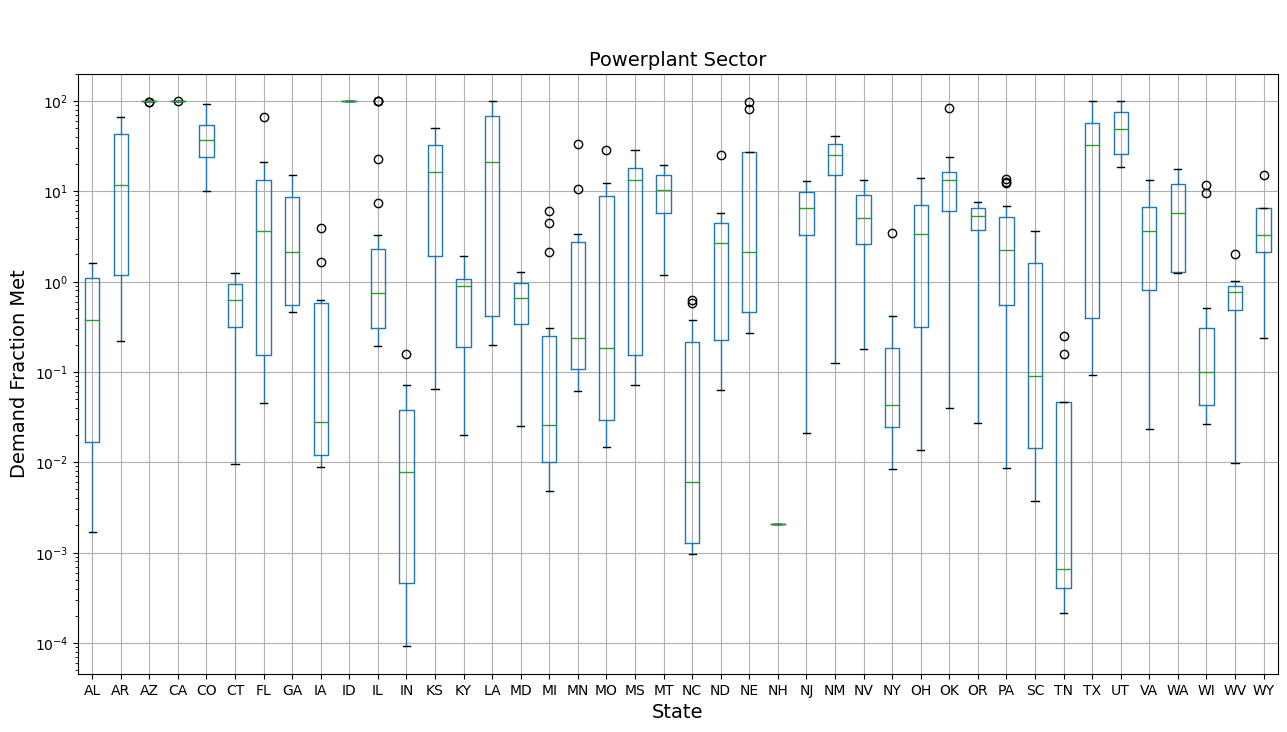

In [48]:
ax = one_pp_many_bw_all_states_df_plot.boxplot('Cum_PPDemandFracMet',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('Demand Fraction Met',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
# ax.set_ylim([0,100])
plt.yscale('log')
plt.suptitle(' ')

Text(0.5, 0.98, ' ')

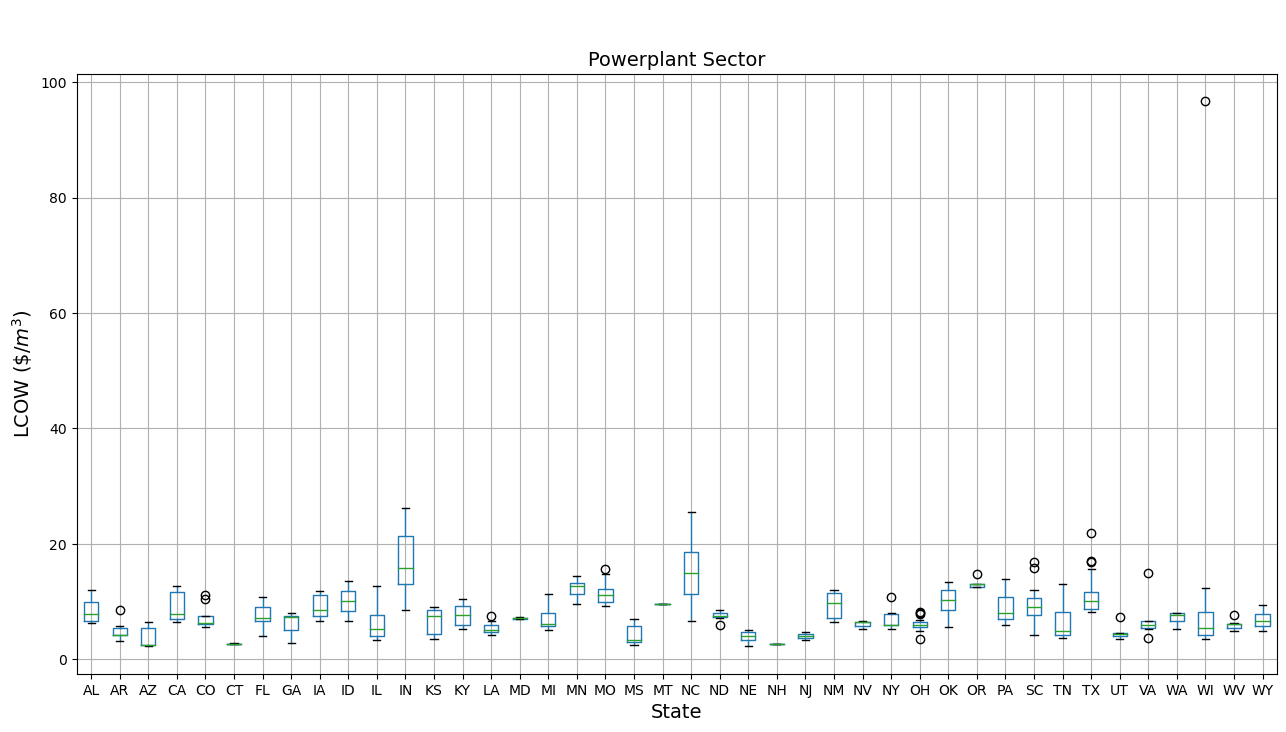

In [38]:
ax= one_pp_many_bw_all_states_df_plot.boxplot('WeightedtLCOW',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
# ax.set_ylim([0,1.6])
plt.suptitle(' ')

In [43]:
max_LCOW = 1.6
one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[(one_pp_many_bw_all_states_df_read['Cum_PPDemandFracMet']<=1) 
                                        & (one_pp_many_bw_all_states_df_read['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

# one_pp_many_bw_all_states_df_plot = one_pp_many_bw_all_states_df_read[ (one_pp_many_bw_all_states_df_read['WeightedtLCOW']<=max_LCOW)].groupby('PlantCode').last()

In [44]:
one_pp_many_bw_all_states_df_plot

,State,PPLatitude,PPLongitude,PPDemand,BWSites,BWLatitude,BWLongitude,BWAvailable,Distance_km,PPDemandFracMet,LCOW,TransportLCOW,tLCOW,WeightedtLCOW,Cum_PPDemandFracMet
PlantCode,,,,,,,,,,,,,,,
10,AL,32.60170,-87.7811,32.119974,USGS-323012087492701,32.503471,-87.824181,0.032961,11.644975,0.001026,0.954613,0.510686,1.465299,1.465299,0.001026
51,LA,32.03056,-93.5692,0.433224,USGS-322052093374701,32.347935,-93.629898,0.044608,35.749762,0.102967,0.819837,1.160315,1.980152,1.562555,0.303102
87,NM,35.41590,-108.0820,0.126887,FETH-351645N1075900.1,35.279167,-107.983361,0.087078,17.640843,0.686266,0.763707,0.446507,1.210214,1.210214,0.686266
113,AZ,34.93940,-110.3030,0.536009,USGS-345306110170801,34.885025,-110.286232,0.043902,6.236558,0.081905,0.889411,0.284448,1.173858,0.972838,0.951541
126,AZ,32.16000,-110.9050,0.176372,USGS-321129110593401,32.190632,-110.992867,0.071813,8.943801,0.407167,0.752811,0.290384,1.043196,1.029606,0.869516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59326,OH,39.46500,-84.3478,0.100572,USGS-393853084170700,39.648113,-84.285217,0.093691,21.056319,0.931577,0.725425,0.499544,1.224969,1.224969,0.931577
59338,AZ,32.97500,-112.6940,0.148293,USGS-325820112420201,32.972267,-112.701279,0.139695,0.743882,0.942017,0.765505,0.086037,0.851542,0.851542,0.942017
59784,AZ,32.97500,-112.6940,0.142832,USGS-325820112420201,32.972267,-112.701279,0.139695,0.743882,0.978034,0.765505,0.086037,0.851542,0.851542,0.978034


Text(0.5, 0.98, ' ')

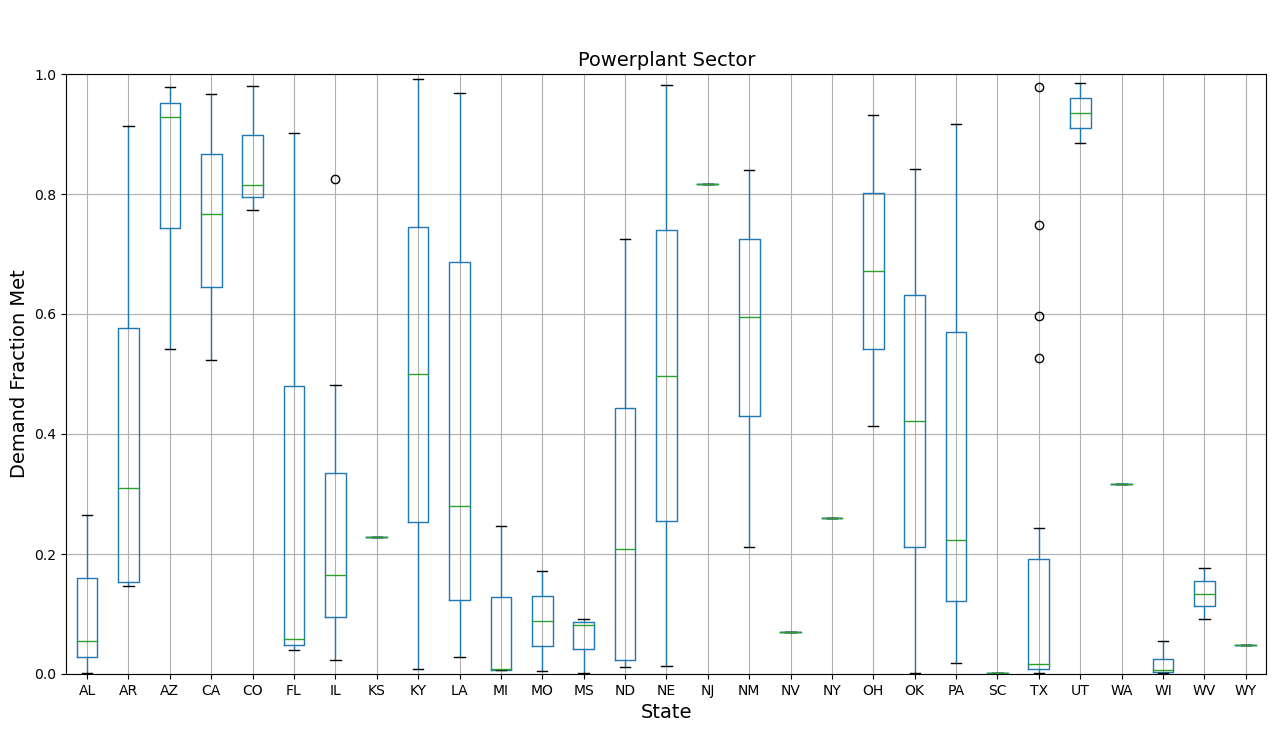

In [45]:
ax = one_pp_many_bw_all_states_df_plot.boxplot('Cum_PPDemandFracMet',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('Demand Fraction Met',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
ax.set_ylim([0,1])
# plt.yscale('log')
plt.suptitle(' ')

Text(0.5, 0.98, ' ')

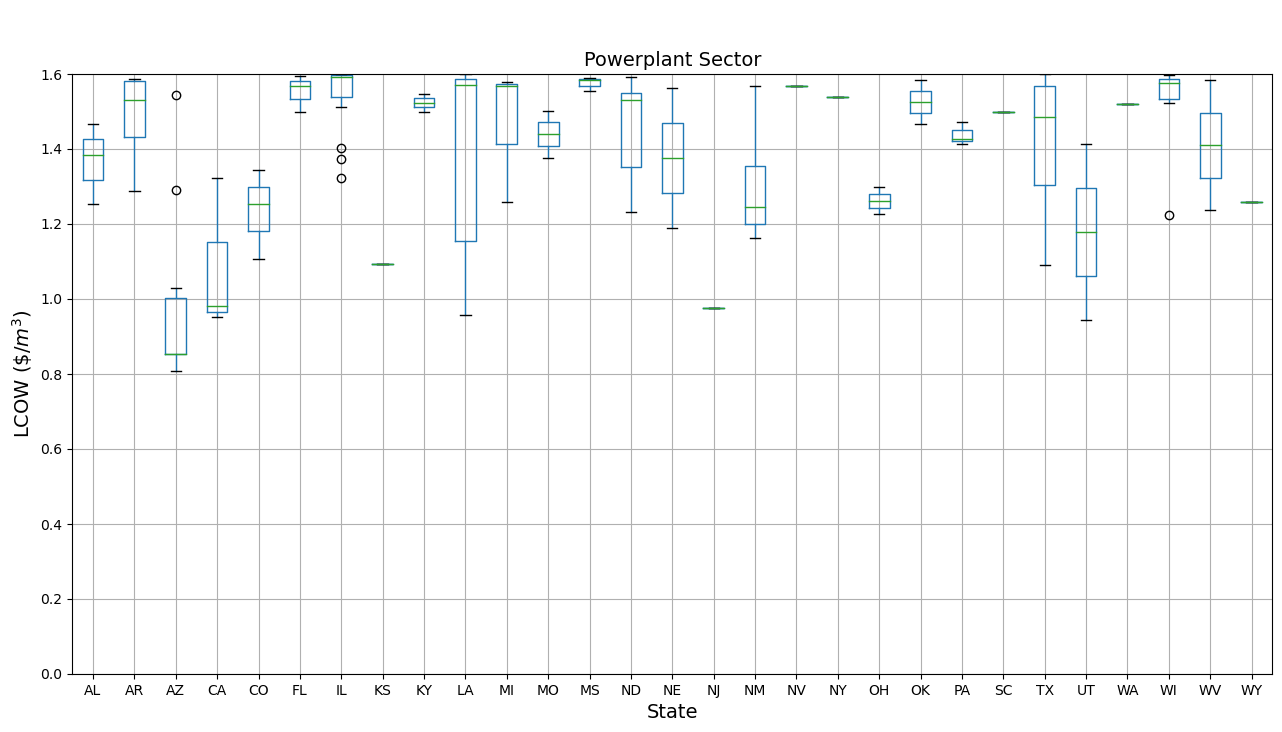

In [46]:
ax= one_pp_many_bw_all_states_df_plot.boxplot('WeightedtLCOW',by='State',figsize = (15,8))
ax.set_title( 'Powerplant Sector',fontsize = 14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize = 14)
ax.set_xlabel('State',fontsize = 14)
ax.set_ylim([0,1.6])
plt.suptitle(' ')